# HW10: Algorithmic Fairness 

### Note: to complete most of this homework notions from week 11 slides are needed

In this homework you will assess racial bias in the COMPAS algorithm and judges decisions. 

The data is a collection of 7000 criminal cases in Florida in which COMPAS was used and it contains information about defendants' demographics, criminal history (e.g., juvenile criminal records), court decision and recidivism.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

## Data Preparation

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [4]:
df['days_from_recid'] = pd.to_datetime(df['r_offense_date']) - pd.to_datetime(df['c_offense_date'])
df['days_from_recid'] = df['days_from_recid'].dt.days
df['two_year_recid2'] = (df['days_from_recid']<=730).astype(int)

#generate felony charge dummies
df['felony'] = (df['c_charge_degree'] == 'F').astype(int)

#generate age dummies
d = pd.get_dummies(df['age_cat'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'25 - 45':'age_cat_25 - 45', 'Greater than 45':'age_cat_Greater than 45', 'Less than 25':'age_cat_Less than 25'})

#generate ethnicity, race and compas score dummies
d = pd.get_dummies(df['race'])
df = pd.concat([df, d], axis=1)
df['male'] = (df['sex'] == 'Male').astype(int)
d = pd.get_dummies(df['score_text'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'High':'score_text_high', 'Medium':'score_text_medium', 'Low':'score_text_low'})

### Setting outcomes and predictors

The *ideal* target variable for the COMPAS algorithm is the presence of a recidivism episode, while for judges is the decision to send the defendant to jail. For the predictors we use some deomgraphic characteristics **excluding race**, criminal hisotry and type of crime. 

In [5]:
# judge decision: "jailed" = more than one day in jail.
df['jail_days'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
df['jailed'] = (df.jail_days.dt.days > 1).astype(int)
D = df['jailed']
D.value_counts()

0    4283
1    2931
Name: jailed, dtype: int64

In [6]:
# Algorithm outcome
Y = df['two_year_recid2'] 
Y.value_counts()

0    4557
1    2657
Name: two_year_recid2, dtype: int64

In [7]:
# predictors
predictors = ['felony',
              'male', 'age', 
              'juv_fel_count','juv_misd_count', 'juv_other_count', 'priors_count']
X = df[predictors]
X.describe()

,felony,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,0.646798,0.806626,34.817993,0.067230,0.090934,0.109371,3.472415
std,0.477998,0.394971,11.888922,0.473972,0.485239,0.501586,4.882538
min,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,42.000000,0.000000,0.000000,0.000000,5.000000
max,1.000000,1.000000,96.000000,20.000000,13.000000,17.000000,38.000000


In [8]:
df['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

In [9]:
# indicator variable for non-white
NW = (df['race'] != 'Caucasian').astype(int)
NW.describe()

count    7214.000000
mean        0.659828
std         0.473800
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: race, dtype: float64

## Assessing Algorithm: Predict Recidivism from Features

In the following you will predict recidivism from defendants' features using a nested training/test split so we can get clean test-set predictions for the whole dataset (see the notebook and homework on double machine learning for how to do this - week 6).

In [58]:
# perform nested train/test split 
from sklearn.model_selection import train_test_split
X_a, X_b, Y_a, Y_b, D_a, D_b,NW_a, NW_b = train_test_split(X, Y, D, NW, test_size = 0.5)

df_pred = X_a.append(X_b) 
#TODO train a logit model to predict recidism (Y) from predictors (X).
#TODO form clean test-set predictions for recidivism in the full dataset
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_a, Y_a)
y_pred = clf.predict(X_b)

Evaluate test set performance.

[[2075  202]
 [1047  283]]
              precision    recall  f1-score   support

           0       0.66      0.91      0.77      2277
           1       0.58      0.21      0.31      1330

    accuracy                           0.65      3607
   macro avg       0.62      0.56      0.54      3607
weighted avg       0.63      0.65      0.60      3607

ROC-AUC Score:  0.5620343678696081


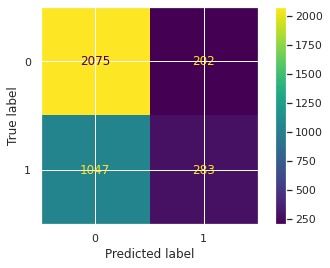

In [25]:
#TODO show a confusion matrix, compute accuracy, balanced accuracy, and roc_auc
#TODO compute ratio of false positives to false negatives

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report

print(confusion_matrix(Y_b, y_pred))
plot_confusion_matrix(clf, X_b, Y_b)
print(classification_report(Y_b, y_pred))
print("ROC-AUC Score: ",roc_auc_score(Y_b, y_pred))

### Compare treatment of whites and non-whites for recidivism prediction
##### Refer to week 11 for these concepts

#### Base Rates

In [27]:
##TODO Compare base rates for recidivism outcomes of whites and non-whites
print("In the groundtruth labels rate of whites committing crime: ", round(Y_b[NW_b==1].sum()/ Y_b.count(), 2))
print("In the groundtruth labels rate of non-whites committing crime: ", round(Y_b[NW_b==0].sum()/ Y_b.count(), 2))

print("In the predictions rate of whites committing crime: ", round(y_pred[NW_b==1].sum()/ y_pred.shape[0], 2))
print("In the predictions labels rate of non-whites committing crime: ", round(y_pred[NW_b==0].sum()/ y_pred.shape[0], 2))

In the groundtruth labels rate of whites committing crime:  0.26
In the groundtruth labels rate of non-whites committing crime:  0.11
In the predictions rate of whites committing crime:  0.11
In the predictions labels rate of non-whites committing crime:  0.02


#### Performance

For Whites
[[1289  165]
 [ 691  238]]


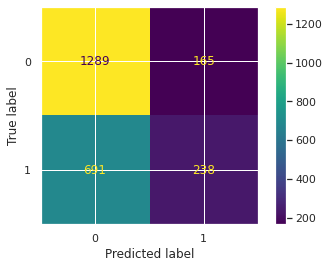

In [29]:
##TODO Produce confusion matrices, classification reports, and ratio of false positives to false negatives, separately for whites and non-whites.
print("For Whites")
print(confusion_matrix(Y_b[NW_b==1], y_pred[NW_b==1]))
plot_confusion_matrix(clf, X_b[NW_b==1], Y_b[NW_b==1])
plt.show() 

For Non-Whites
[[786  37]
 [356  45]]


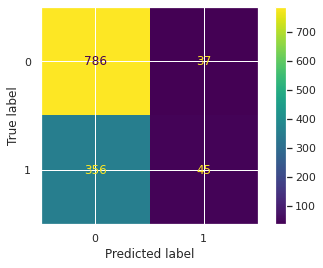

In [30]:
print("For Non-Whites")
print(confusion_matrix(Y_b[NW_b==0], y_pred[NW_b==0]))
plot_confusion_matrix(clf, X_b[NW_b==0], Y_b[NW_b==0])
plt.show() 

**What concepts of "fairness" (from class) are (approximately) satisfied by this classifier? Explain.**

## Assessing Judges' Decisions: Predict Judge Decision from Features

In the following you will predict judges' decisions from defendants' features using a nested training/test split as before. In a second model, include Y-hat from previous section as a predictor.

In [59]:
#TODO train a logit model to predict judge decision (D) from predictors (X). 
clf2 = LogisticRegression(random_state=0).fit(X_a, D_a)
D_hat_b = clf.predict(X_b)
Y_hat_a = clf.predict(X_a)

In [33]:
#TODO train a logit model to predict judge decision (D) from predictors (X) and predicted recidivism risk (Yhat)
#TODO form clean test-set predictions for the decisions in the full dataset
X_a["Y_hat"] = Y_hat_a
X_b["Y_hat"] = y_pred
clf3 = LogisticRegression(random_state=0).fit(X_a, D_a)
D_hat_b = clf3.predict(X_b)

### Compare treatment of whites and non-whites for recidivism prediction

For Whites
[[1289  165]
 [ 691  238]]


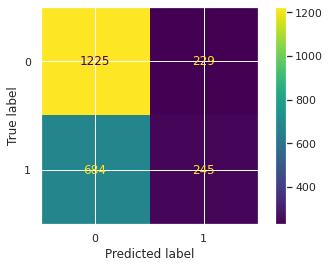

In [34]:
##TODO Produce confusion matrices, classification reports, and ratio of false positives to false negatives, 
##TODO separately for whites and non-whites, and with/without including Y-hat as a predictor.
print("For Whites")
print(confusion_matrix(Y_b[NW_b==1], y_pred[NW_b==1]))
plot_confusion_matrix(clf3, X_b[NW_b==1], Y_b[NW_b==1])
plt.show()

For Non-Whites
[[786  37]
 [356  45]]


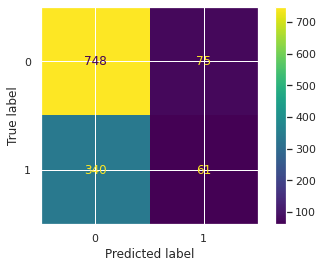

In [35]:
print("For Non-Whites")
print(confusion_matrix(Y_b[NW_b==0], y_pred[NW_b==0]))
plot_confusion_matrix(clf3, X_b[NW_b==0], Y_b[NW_b==0])
plt.show()

### Enforcing Statistical Parity

In this part you will find the the group-specific thresholds for both models of judges' decision (with/without Yhat) that obtain statistical parity.

You can use a custom classifier `threshold` for the decision with this type of code snippet: `decisions = (logit.predict_proba(X) >= threshold).astype(int)`.

#### Model without Yhat

In [60]:
##Find the largest and lowest thresholds to enforce statistical parity
##hint: build a recursive function to find the probability threshold that minimizes 
## the difference between the predicted outcomes for whites and non whites
import numpy as np

def custom_predict(logit, X, th):
  return (logit.predict_proba(X)[:, 1] >= th).astype(int)

thresholds = np.arange(0.1, 1.0, 0.1)
min_diff = np.inf
for th in thresholds:
  y_pred = custom_predict(clf2, X_b, th)
  y_pred_nonwhite = sum(y_pred[NW_b==0])
  y_pred_white = sum(y_pred[NW_b==1])
  if min_diff > abs(y_pred_white-y_pred_nonwhite):
    min_diff = abs(y_pred_white-y_pred_nonwhite)
    optimal_threshold = th
print("The optimal threshold for statistical parity is", optimal_threshold)

The optimal threshold for statistical parity is 0.9


#### Model with Yhat

In [57]:
##Find the largest and lowest thresholds to enforce statistical parity
##hint: build a recursive function to find the probability threshold that minimizes 
## the difference between the predicted outcomes for whites and non whites

thresholds = np.arange(0.1, 1.0, 0.1)
min_diff = np.inf
for th in thresholds:
  y_pred = custom_predict(clf3, X_b, th)
  y_pred_nonwhite = sum(y_pred[NW_b==0])
  y_pred_white = sum(y_pred[NW_b==1])
  if min_diff > abs(y_pred_white-y_pred_nonwhite):
    min_diff = abs(y_pred_white-y_pred_nonwhite)
    optimal_threshold = th
print("The optimal threshold for statistical parity is", optimal_threshold)

The optimal threshold for statistical parity is  0.9


# Bonus 1: More Fairness Constraints

Find the threshold for both models (with/without Yhat) that obtains error rate balance (equality of recalls for each class.

In [ ]:
##TODO

Find the threshold for both models (with/without Yhat) that obtains predictive parity (equality of precisions for each class).

In [ ]:
##TODO

Find the threshold for both models (with/without Yhat) that obtains treatment equality (ratio of false positives to false negatives).

In [ ]:
##TODO

# Bonus 2: Pre-Processing for Fairness

Regress all predictors in `X` on the protected attribute `A` and produce residuals `Xtilde`. Re-do the prediction task above (predicting judges' decision) and discuss how it changes the fairness metrics.

In [ ]:
##TODO